# SVC Backtesting

In [20]:
import pandas as pd
import numpy as np
from backtesting import Backtest, Strategy

# Set random seed
np.random.seed(42)

# Load and clean the CSV
df = pd.read_csv("../Data/^GSPC.csv")
df = df[df["Price"] != "Ticker"]
df = df[df["Price"] != "Date"]
df[['Close','High', 'Low', 'Open', 'Volume']] = df[['Close', 'High', 'Low', 'Open', 'Volume']].astype(float)
df['Price'] = pd.to_datetime(df['Price'])
df.set_index('Price', inplace=True)
df.index.name = None

# Define feature generation
def add_features(data):
    """Create additional technical indicators and prediction target while keeping alignment intact"""
    df = data.copy()

    # Technical indicators
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA10'] = df['Close'].rolling(window=10).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['Volatility'] = df['Close'].pct_change().rolling(window=10).std()
    df['Momentum'] = df['Close'] - df['Close'].shift(5)
    df['Return'] = df['Close'].pct_change()

    # Feature engineering
    df['X_MA5'] = (df['Close'] - df['MA5']) / df['Close']
    df['X_MA10'] = (df['Close'] - df['MA10']) / df['Close']
    df['X_MA20'] = (df['Close'] - df['MA20']) / df['Close']
    df['X_MA5_10'] = (df['MA5'] - df['MA10']) / df['Close']
    df['X_MA10_20'] = (df['MA10'] - df['MA20']) / df['Close']
    df['X_Volatility'] = df['Volatility']
    df['X_Momentum'] = df['Momentum']
    df['X_Return'] = df['Return']
    df['X_Return_5'] = df['Return'].rolling(5).sum()
    df['X_VOL_CHG'] = df['Volume'].pct_change(5)

    # Target: use binary or multi-class depending on your setup
    df['Target'] = np.where(df['Return'].shift(-1) > 0.005, 1,
                    np.where(df['Return'].shift(-1) < -0.005, -1, 0))

    return df  # ❗ Keep full index, no dropna()

# Helper functions to extract features and labels
def get_X(data):
    feature_columns = [col for col in data.columns if col.startswith('X_')]
    return data[feature_columns].values

def get_y(data):
    return data.Target.values

# Apply features
df = add_features(df)

In [21]:
from sklearn.svm import SVC
from backtesting import Strategy
import numpy as np

class strategy_class(Strategy):
    def init(self):
        self.model = SVC(probability=True, random_state=42)

        # Extract features
        self.features = [col for col in self.data.df.columns if col.startswith("X_")]

        # Feature engineering
        self.df = add_features(self.data.df).fillna(method='ffill').fillna(method='bfill')

        # For plotting predictions
        self.pred = self.I(lambda: np.zeros(len(self.data)), name='pred')

        # For post-evaluation
        self.predictions = []
        self.actuals = []

    def next(self):
        i = len(self.data)
        if i < 200:
            return

        # Prepare training and test data
        train = self.df.iloc[i-200:i]
        test = self.df.iloc[[i-1]]

        X_train = train[self.features].values
        y_train = train["Target"].values
        X_test = test[self.features].values
        y_true = test["Target"].values[0]

        # Fit model and predict
        self.model.fit(X_train, y_train)
        prediction = self.model.predict(X_test)[0]
        self.pred[-1] = prediction

        # Store prediction and actual label
        if prediction in [-1, 0, 1]:
            self.predictions.append(prediction)
            self.actuals.append(int(y_true))

        # Execute trade
        if prediction == 1:
            if not self.position.is_long:
                self.position.close()
                self.buy()
        elif prediction == -1:
            if not self.position.is_short:
                self.position.close()
                self.sell()

In [25]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_strategy(y_true, y_pred):

    print("📈 Evaluation Metrics")
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 4))
    print("Precision (macro):", round(precision_score(y_true, y_pred, average='macro'), 4))
    print("F1 Score (macro):", round(f1_score(y_true, y_pred, average='macro'), 4))

    cm = confusion_matrix(y_true, y_pred, labels=[-1, 0, 1])
    disp = ConfusionMatrixDisplay(cm, display_labels=['Down (-1)', 'Neutral (0)', 'Up (1)'])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

In [24]:

bt = Backtest(df, strategy_class, cash=10000, commission=0.001)
backtest = bt.run()
backtest

/var/folders/46/zqdj50yj7l759m_vn_js8z0w0000gn/T/ipykernel_98641/21213105.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.df = add_features(self.data.df).fillna(method='ffill').fillna(method='bfill')


Start                     2020-01-30 00:00:00
End                       2023-12-29 00:00:00
Duration                   1429 days 00:00:00
Exposure Time [%]                    66.56535
Equity Final [$]                  12164.09463
Equity Peak [$]                    14959.5123
Commissions [$]                    1285.45886
Return [%]                           21.64095
Buy & Hold Return [%]                45.25956
Return (Ann.) [%]                     5.12899
Volatility (Ann.) [%]                12.48874
CAGR [%]                              3.51507
Sharpe Ratio                          0.41069
Sortino Ratio                          0.6104
Calmar Ratio                          0.18712
Alpha [%]                            17.64029
Beta                                  0.08839
Max. Drawdown [%]                   -27.40957
Avg. Drawdown [%]                    -1.90595
Max. Drawdown Duration      455 days 00:00:00
Avg. Drawdown Duration       21 days 00:00:00
# Trades                          

📈 Evaluation Metrics
Accuracy: 0.4797
Precision (macro): 0.4425
F1 Score (macro): 0.438


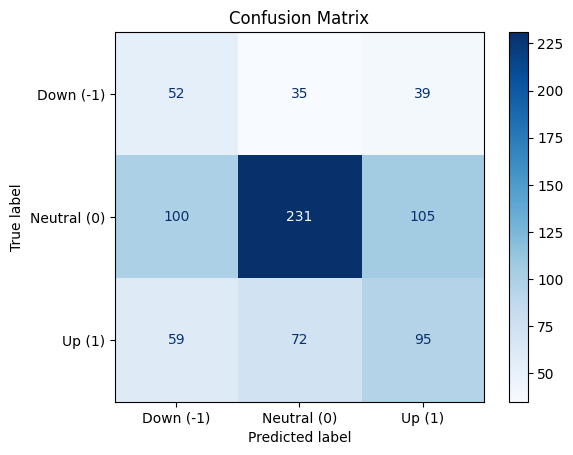

In [26]:
predictions = backtest._strategy.predictions
actuals = backtest._strategy.actuals
evaluate_strategy(predictions, actuals)

In [28]:
bt.plot()

/Users/aroncheng/backtest-env/lib/python3.9/site-packages/backtesting/_plotting.py:701: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/Users/aroncheng/backtest-env/lib/python3.9/site-packages/backtesting/_plotting.py:701: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p2548', ...)